In [2]:
from tensorflow.keras.layers import Input,Dense,Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as pretrainedModel
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d trolukovich/food5k-image-dataset

 99% 423M/426M [00:02<00:00, 190MB/s]
100% 426M/426M [00:02<00:00, 190MB/s]


In [5]:
!unzip -qq -o food5k-image-dataset.zip

In [6]:
IMAGE_SIZE=[200,200]
batch_size=128
train_path='/content/training'
valid_path='/content/validation'
image_files=glob(train_path+'/*/*.jpg')
valid_image_files=glob(valid_path+'/*/*.jpg')
folders=['training/food','training/non_food']

In [7]:
ptm=pretrainedModel(input_shape=IMAGE_SIZE+[3],include_top=False,weights='imagenet')
x=Flatten()(ptm.output)

58889256/58889256 [==============================] - 0s 0us/step


In [8]:
model=Model(inputs=ptm.input,outputs=x)

In [9]:
ptm.input.shape

TensorShape([None, 200, 200, 3])

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [11]:
gen=ImageDataGenerator(preprocessing_function=preprocess_input)

In [12]:
batch_size=128

train_generator=gen.flow_from_directory(
    train_path,shuffle=True,target_size=IMAGE_SIZE,batch_size=batch_size,class_mode='binary'
)

valid_generator=gen.flow_from_directory(
    valid_path,target_size=IMAGE_SIZE,batch_size=batch_size,class_mode='binary'
)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [27]:
Ntrain=len(image_files)
Nvalid=len(valid_image_files)

feat=model.predict(np.random.random([1]+IMAGE_SIZE+[3]))
D=feat.shape[1]

X_train=np.zeros((Ntrain,D))
y_train=np.zeros((Ntrain))
X_valid=np.zeros((Nvalid,D))
y_valid=np.zeros((Nvalid))

1/1 [==============================] - 0s 34ms/step


In [28]:
i=0
for x,y in train_generator:
  features=model.predict(x)
  sz=len(y)  #size of batch(size of last batch may be diffrent)
  X_train[i:i+sz]=features
  y_train[i:i+sz]=y
  i+=sz
  print(i)
  if(i>=Ntrain):
    print('break')
    break
print(i)

4/4 [==============================] - 0s 115ms/step
128
4/4 [==============================] - 0s 97ms/step
256
4/4 [==============================] - 0s 99ms/step
384
4/4 [==============================] - 0s 121ms/step
512
4/4 [==============================] - 0s 116ms/step
640
4/4 [==============================] - 0s 115ms/step
768
4/4 [==============================] - 0s 98ms/step
896
4/4 [==============================] - 0s 98ms/step
1024
4/4 [==============================] - 0s 99ms/step
1152
4/4 [==============================] - 0s 98ms/step
1280
4/4 [==============================] - 0s 98ms/step
1408
4/4 [==============================] - 0s 98ms/step
1536
4/4 [==============================] - 0s 100ms/step
1664
2/2 [==============================] - 0s 94ms/step
1720
4/4 [==============================] - 0s 99ms/step
1848
4/4 [==============================] - 0s 100ms/step
1976
4/4 [==============================] - 0s 99ms/step
2104
4/4 [===========================

In [29]:
i=0
for x,y in valid_generator:
  features=model.predict(x)
  sz=len(y)  #size of batch(size of last batch may be diffrent)
  X_valid[i:i+sz]=features
  y_valid[i:i+sz]=y
  i+=sz
  print(i)
  if(i>=Nvalid):
    print('break')
    break
print(i)

4/4 [==============================] - 0s 100ms/step
128
4/4 [==============================] - 0s 99ms/step
256
4/4 [==============================] - 0s 100ms/step
384
4/4 [==============================] - 0s 99ms/step
512
4/4 [==============================] - 0s 100ms/step
640
4/4 [==============================] - 0s 100ms/step
768
4/4 [==============================] - 0s 100ms/step
896
4/4 [==============================] - 0s 99ms/step
1000
break
1000


In [30]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()

X_train2=scaler.fit_transform(X_train)
X_valid2=scaler.transform(X_valid)

In [31]:
from sklearn.linear_model import LogisticRegression
logr=LogisticRegression()
logr.fit(X_train2,y_train)
print(logr.score(X_train2,y_train))
print(logr.score(X_valid2,y_valid))

1.0
0.984


In [33]:
# logistic regressiom in tensorflow

i=Input(shape=(D,))
x=Dense(1,activation='sigmoid')(i)
linear_model=Model(i,x)

In [35]:
linear_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [36]:
r=linear_model.fit(X_train,y_train,batch_size=128,epochs=10,validation_data=(X_valid,y_valid))

Epoch 1/10
24/24 [==============================] - 2s 34ms/step - loss: 0.5117 - accuracy: 0.9550 - val_loss: 0.2770 - val_accuracy: 0.9810
Epoch 2/10
24/24 [==============================] - 0s 9ms/step - loss: 0.0593 - accuracy: 0.9957 - val_loss: 0.2329 - val_accuracy: 0.9780
Epoch 3/10
24/24 [==============================] - 0s 10ms/step - loss: 0.0090 - accuracy: 0.9983 - val_loss: 0.1962 - val_accuracy: 0.9850
Epoch 4/10
24/24 [==============================] - 0s 13ms/step - loss: 4.3308e-05 - accuracy: 1.0000 - val_loss: 0.1956 - val_accuracy: 0.9830
Epoch 5/10
24/24 [==============================] - 0s 14ms/step - loss: 9.3171e-06 - accuracy: 1.0000 - val_loss: 0.1945 - val_accuracy: 0.9830
Epoch 6/10
24/24 [==============================] - 0s 17ms/step - loss: 4.3792e-06 - accuracy: 1.0000 - val_loss: 0.1935 - val_accuracy: 0.9830
Epoch 7/10
24/24 [==============================] - 0s 13ms/step - loss: 2.9680e-06 - accuracy: 1.0000 - val_loss: 0.1927 - val_accuracy: 0.983

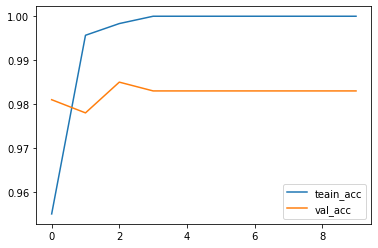

In [37]:
plt.plot(r.history['accuracy'],label='teain_acc')
plt.plot(r.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()

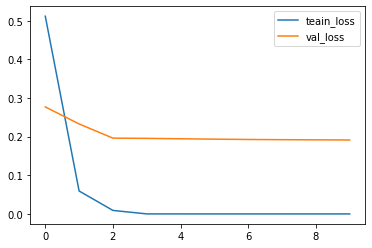

In [38]:
plt.plot(r.history['loss'],label='teain_loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()
plt.show()